## Scraping Buying House Web

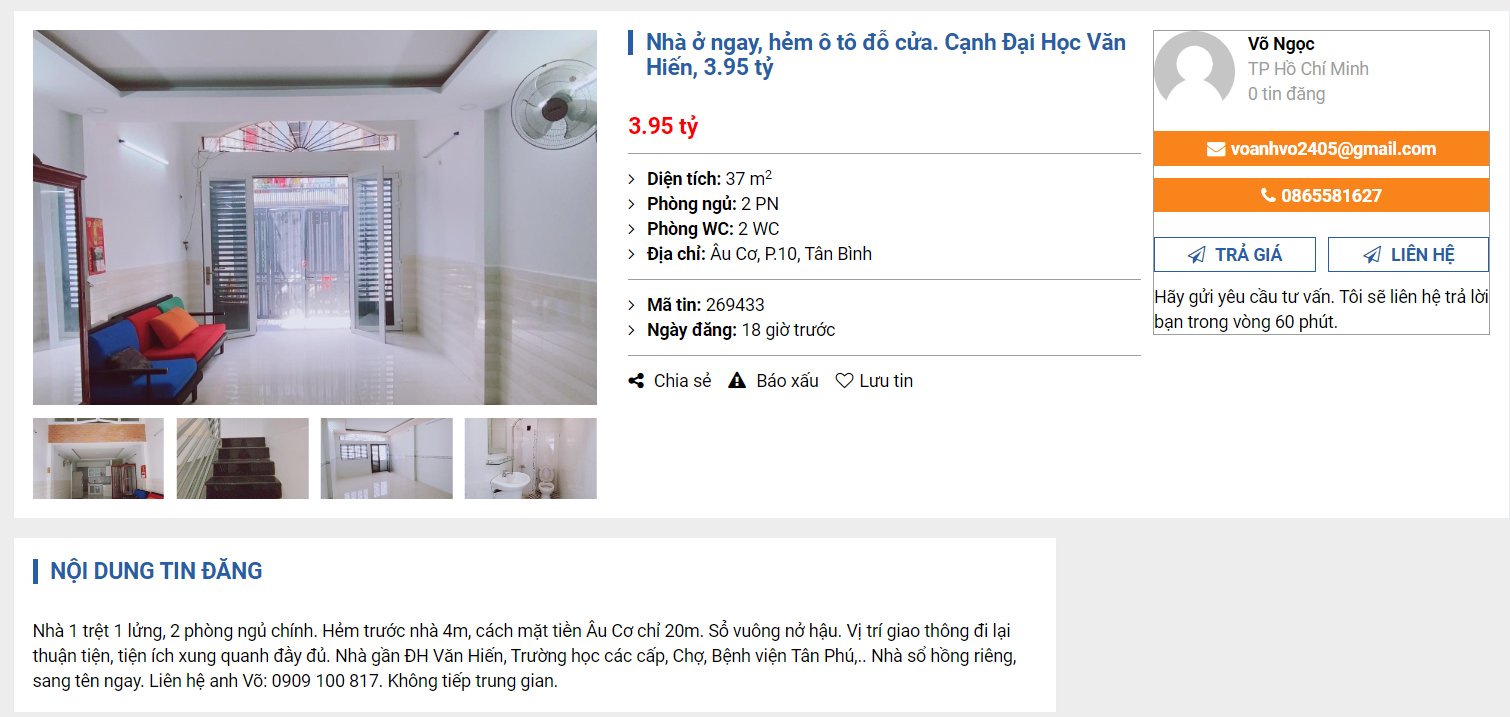

### Import Libraries

In [1]:
from bs4 import BeautifulSoup
import urllib.request
import requests
import re

### Scraping

In [2]:
def download_html(url):
    with urllib.request.urlopen(url) as response:
        html = response.read()
        html = html.decode('utf-8')
    response.close()
    return html

In [3]:
def scrape_block(buying_house_blocks):
    try:
        url = buying_house_blocks.find('a').get('href')
        source = download_html(url)
    except:
        source = ''
    soup = BeautifulSoup(source, 'lxml') #html.parser
    info_custom = soup.find('div',{'class':'project-global-object-block-003 information-custom'})
    block_custom = soup.find('div',{'class':'project-global-object-block-003 block-custom'})
    uk_breadcrumb = soup.find('ul',{'class':'uk-breadcrumb'})
    buying_house_data ={}

    try:
        buying_house_data['datetime'] = info_custom.find('time',{'class':'timeago'}).get('datetime')
    except:
        buying_house_data['datetime'] = None

    try:
        buying_house_data['title'] = info_custom.find('h1').get_text()
    except:
        buying_house_data['title'] = None

    try:
        buying_house_data['link'] = buying_house_blocks.find('a').get('href')
    except:
        buying_house_data['link'] = None

    try:
        breadcrumb = uk_breadcrumb.findAll('a')
        buying_house_data['house_type'] = re.split('Bán\s+',breadcrumb[1].get_text())[1]
    except:
        buying_house_data['house_type'] = None

    try:
        price = info_custom.find('strong',{'class':'price'}).get_text().strip()
        buying_house_data['price'] = price
    except:
        buying_house_data['price'] = None

    try:
        text = r'Diện tích:'
        element = info_custom.find(lambda tag: tag.name == "strong" and text in tag.text)
        buying_house_data['acreage'] = element.next_sibling.get_text().strip()
    except:
        buying_house_data['acreage'] = None

    try:
        text = r'Địa chỉ:'
        element = info_custom.find(lambda tag: tag.name == "strong" and text in tag.text)
        buying_house_data['address'] = element.next_sibling.get_text().strip()
    except:
        buying_house_data['address'] = None

    try:
        breadcrumb = uk_breadcrumb.findAll('a')
        district = breadcrumb[3].get_text()
        buying_house_data['district'] = district
    except:
        buying_house_data['district'] = None

    try:
        breadcrumb = uk_breadcrumb.findAll('a')
        city = breadcrumb[2].get_text()
        buying_house_data['city'] = city
    except:
        buying_house_data['city'] = None

    try:
        text = r'Phòng ngủ:'
        element = info_custom.find(lambda tag: tag.name == "strong" and text in tag.text)
        buying_house_data['bedrooms'] = element.next_sibling.get_text().strip()
    except:
        buying_house_data['bedrooms'] = None

    try:
        text = r'Phòng WC:'
        element = info_custom.find(lambda tag: tag.name == "strong" and text in tag.text)
        buying_house_data['wc'] = element.next_sibling.get_text().strip()
    except:
        buying_house_data['wc'] = None

    try:
        text = r'Hướng nhà:'
        element = info_custom.find(lambda tag: tag.name == "strong" and text in tag.text)
        buying_house_data['house_direction'] = element.next_sibling.get_text().strip()
    except:
        buying_house_data['house_direction'] = None

    try:
        text = r'Hướng ban công:'
        element = info_custom.find(lambda tag: tag.name == "strong" and text in tag.text)
        buying_house_data['balcony_direction'] = element.next_sibling.get_text().strip()
    except:
        buying_house_data['balcony_direction'] = None

    try:
        buying_house_data['description'] = block_custom.find('p').get_text()
    except:
        buying_house_data['description'] = None

    return buying_house_data

In [4]:
def scrape_page(buying_house_blocks):

    page_buying_house_data = []
    num_blocks = len(buying_house_blocks)

    for block in range(num_blocks):
        page_buying_house_data.append(scrape_block(buying_house_blocks[block]))

    return page_buying_house_data

In [5]:
import time
import random as ran
def scrape_this(link,start,end):

    #from IPython.core.debugger import set_trace

    base_url = link

    page_number = start

    buying_house_data = []
    while page_number <= end:

        url = base_url + str(page_number)

        #set_trace()

        source = download_html(url)
        soup = BeautifulSoup(source, 'lxml') # lxml

        buying_house_blocks = (soup.find('div',{'class':'project-global-object-block-002 realestate-post-list-custom block-custom'})).findAll('div',{'class':'name'})

        buying_house_data.extend(scrape_page(buying_house_blocks))


        print('\r' + "currently scraping movies from: " + str(page_number) + " - "+str(end), "| remaining count: " + str(end-page_number), flush=True, end ="\n")

        page_number+=1

        time.sleep(ran.randint(0, 10))

    return buying_house_data

In [ ]:
import pandas as pd
base_scraping_link = "https://batdongsan.vn/ban-nha/p"

start = 1
end = 100
buying_houses = []

buying_houses = scrape_this(base_scraping_link,int(start),int(end))

print('\r'+"List of " + str(start) + "-" + str(end),"pages of buying houses:" + "\n", end= "")
buying_houses=pd.DataFrame(buying_houses)
buying_houses.head()


Writing to csv for next steps

In [ ]:
buying_houses.to_csv('merged_data.csv', encoding='utf-8-sig', index = False)


## Preliminar Data Engineering for the data extracted by web crawler



### Import libraries

In [6]:
import pandas as pd
import numpy as np
import re
import os

In [ ]:
merged_data = pd.read_csv('merge_data.csv')

In [ ]:
data = merged_data.copy()

### Some functions used for data processing

Convert string to number

In [8]:
def convert_string_to_number(string):
    # Tạo từ điển ánh xạ chữ thành số
    number_mapping = {
        'một': 1,
        'hai': 2,
        'ba': 3,
        'bốn' : 4,
        'năm' : 5,
        'sáu' : 6,
        'bảy' : 7,
        'tám' : 8,
        'chín' : 9,
        'mười' : 10
    }

    # Tách chuỗi thành các từ riêng lẻ
    words = string.lower().split()

    # Thay thế các từ chữ thành số theo từ điển ánh xạ
    converted_words = [str(number_mapping[word]) if word in number_mapping else word for word in words]

    # Kết hợp các từ thành chuỗi kết quả
    converted_string = ' '.join(converted_words)

    return converted_string


In [9]:
convert_string_to_number('năm tỷ')

'5 tỷ'

Find number of floors and convert to float

In [11]:

def find_floors(text):
    string = re.search('\d+\s*(?:tầng|Tầng|Tầng|TẦNG|Lầu|lầu|LẦU)',convert_string_to_number(text))
    if string:
        increment = re.search('\d+\s*(?:Lầu|lầu|LẦU)',string.group())
        if increment:
            result = re.sub(r'[^\d]', '', increment.group()) # cộng 1 tầng trệt
            result = int(str(int(result)+1))
        else:
            result = re.sub(r'[^\d]', '', string.group())
    else:
        result = re.findall('(?:tầng|Tầng|Tầng|TẦNG|Lầu|lầu|LẦU)\s*\d+',convert_string_to_number(text))
        if result:
            result = int(re.sub(r'[^\d]', '', result[-1]))
        else:
            return None
    return float(result)

In [12]:
text = 'một trệt 2 lầu'
find_floors(text)

3.0

Find price in some text data like `title`, `description` and convert to float

In [14]:
import re
def convert_price_to_number(text):
    # Tìm và trích xuất các phần số từ chuỗi
    matches = re.findall('\d+\s*(?:tỷ|Tỷ|TỶ|tỉ|TỈ|Tỉ|T\s|Ty|ty|tyy|tyy)(?:\s\d+|\d+)(?:\striệu|\sTriệu|\sTRIỆU|\str|triệu|Triệu|TRIỆU|Trieu|trieu|tr)?', convert_string_to_number(text))
    if matches:
        matches = re.findall('\d+', matches[-1])
        result = float('.'.join(matches))
    else:
        matches = re.findall('(?:\d+|\d+(?:\.|,)\s*(?:\w+|\d+\s))\s*(?:tỷ|Tỷ|TỶ|tỉ|TỈ|Tỉ|T\s|triệu|Triệu|TRIỆU|trieu|Trieu|tr\s|Ty\s|ty\s|Tyy\s|tyy\s)', convert_string_to_number(text))
        if matches:
            result = re.sub(',', '.', matches[-1])
            result = re.sub('(?:\d+|\d+(?:\.|,)\s*(?:\w+|\d+\s))\s*(?:triệu|Triệu|TRIỆU|trieu|Trieu|tr)', lambda x: str(float(re.findall('\d+(?:\.\d+)?', x.group(0))[-1])/1000), result)
            result = float(re.sub('[^\d\.,]','',result))
        else:
            return None
    return float(result)


In [15]:
text = ' năm ty200 triệu'
convert_price_to_number(text)

5.2

Calculate proverty age

In [16]:
from datetime import datetime

def calculate_property_age(listing_date_str):
    # Convert the listing date string to a datetime object
    listing_date = datetime.strptime(listing_date_str, "%Y-%m-%d %H:%M:%S")

    # Get the current date and time
    current_date = datetime.now()

    # Calculate the age of the property
    age = current_date - listing_date

    return age.days

Processing Address

In [17]:
def is_substring(string1, string2):
    return string1.lower() in string2.lower()

###

def process_address(address, district, city):
    if address is None or len(address.strip()) == 0:
        return district + ', ' + city
    elif is_substring(district,address):
        if is_substring(city,address):
            return address
        else:
            return address + ', ' + city
    else:
        return address + ', ' + district + ', ' + city


Get coordinates with longitude and latitude

In [18]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

def get_coordinates(address, district, city):
    geolocator = Nominatim(user_agent='my_app')
    geocode_with_limiter = RateLimiter(geolocator.geocode, min_delay_seconds=1)

    location = geocode_with_limiter(address, limit = 1)

    if location is not None:
        return location.latitude, location.longitude
    else:
        address = district + ', ' + city
        location = geocode_with_limiter(address, limit= 1 )

        if location is not None:
            return location.latitude, location.longitude
        else:
            return None, None


Find `place_type` such as: hospital, school, etc near house

In [ ]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic

def is_nearby_places(latitude, longitude, place_type, radius):
    geolocator = Nominatim(user_agent='my_app')
    geocode_with_limiter = RateLimiter(geolocator.geocode, min_delay_seconds=1)

    location = geolocator.reverse((latitude, longitude), exactly_one=True)
    address = location.address

    # Tìm kiếm các tiện ích gần tọa độ
    query = place_type + " near " + address
    geocode = geocode_with_limiter(query, exactly_one=False, limit=None)

    if geocode is not None:
        for place in geocode:
            place_latitude = place.latitude
            place_longitude = place.longitude

            distance = geodesic((latitude, longitude), (place_latitude, place_longitude)).meters
            if distance <= radius:
                return distance

    return None


## Data Processing

Convert certain columns like `acreage` and `price` from strings to number, and make them uniform

In [ ]:
data.fillna("", inplace = True)
##
data['address'] = data.apply(lambda x: process_address(x['address'],x['district'],x['city']),axis =1)
##
data['price'] = data['price'].apply(lambda x: re.sub(r'(\d+\.\d+|\d+)\s*triệu', lambda y: str(float(y.group(1))/1000) + ' tỷ',x))
data['price'] = data['price'].apply(lambda x: re.sub('[^\d.]','',x))
##
data['acreage'] = data['acreage'].apply(lambda x: re.sub(r'[^0-9.]', '', x))
##
data['bedrooms'] = data['bedrooms'].apply(lambda x: re.sub(r'[^\d]', '', x))
##
data['wc'] = data['wc'].apply(lambda x: re.sub(r'[^\d]', '', x))


Find new data from `title` and `description` to fill missing and anomalous data using regex

In [ ]:
data['price 2'] = data['title'].apply(lambda x: convert_price_to_number(x))
##
data['price 3'] = data['description'].apply(lambda x: convert_price_to_number(x))
##
data['wc 2'] = data['description'].apply(lambda x: re.search('\d+\s*(?:WC|wc|Wc|Nhà vệ sinh|nhà vệ sinh|Vệ sinh|vệ sinh|Toilet|toilet)',convert_string_to_number(x)))
data['wc 2'] = data['wc 2'].apply(lambda x: x.group() if x else None)
data['wc 2'].fillna('', inplace=True)
data['wc 2'] = data['wc 2'].apply(lambda x: re.sub(r'[^\d]', '', x))
#
data['bedrooms 2'] = data['description'].apply(lambda x: re.search('\d+\s*(?:PN|pn|Pn|pngu|Pngu|Phòng ngủ|phòng ngủ|PHÒNG NGỦ|Phòng Ngủ|ngủ|Ngủ|NGỦ)',convert_string_to_number(x)))
data['bedrooms 2'] = data['bedrooms 2'].apply(lambda x: x.group() if x else None)
data['bedrooms 2'].fillna('', inplace=True)
data['bedrooms 2'] = data['bedrooms 2'].apply(lambda x: re.sub(r'[^\d]', '', x))
##
data['floors'] = data['description'].apply(lambda x: find_floors(x))
##
data['floors 2'] = data['title'].apply(lambda x: find_floors(x))
##
data['property age'] = data['datetime'].apply(lambda x: calculate_property_age(x))
##
data['latitude'], data['longitude'] = zip(*data.apply(lambda x: get_coordinates(x['address'], x['district'], x['city']), axis=1))


In [ ]:
# Lọc các hàng có giá trị null trong cột 'latitude' và 'longitude'
null_rows = data[data['latitude'].isnull() | data['longitude'].isnull()]

# Điền giá trị null trong cột 'latitude' và 'longitude' bằng cách gọi hàm get_coordinates
for index, row in null_rows.iterrows():
    latitude, longitude = get_coordinates(row['address'], row['district'], row['city'])
    data.at[index, 'latitude'] = latitude
    data.at[index, 'longitude'] = longitude

In [ ]:
# Tìm hàng có latitude = 13.7989967 và longitude = 100.5491731
row_index = data[(data['latitude'] == 13.7989967) & (data['longitude'] == 100.5491731)].index #coordiate wrong thailand

# Chỉnh sửa giá trị longitude và latitude
data.loc[row_index, 'longitude'] = 105.8300542

data.loc[row_index, 'latitude'] = 21.015036

Find `place_type` near house and return True/False

In [ ]:
import time

radius = 1000

place_type = 'hospital'
try:
    data[place_type] = data.apply(lambda row: is_nearby_places(row['latitude'], row['longitude'], place_type, radius), axis=1)
except Exception as e:
    print(f"Error occurred when finding nearby {place_type}: {str(e)}")
    time.sleep(1)
    data[place_type] = data.apply(lambda row: is_nearby_places(row['latitude'], row['longitude'], place_type, radius), axis=1)

place_type = 'supermarket'
try:
    data[place_type] = data.apply(lambda row: is_nearby_places(row['latitude'], row['longitude'], place_type, radius), axis=1)
except Exception as e:
    print(f"Error occurred when finding nearby {place_type}: {str(e)}")
    time.sleep(1)
    data[place_type] = data.apply(lambda row: is_nearby_places(row['latitude'], row['longitude'], place_type, radius), axis=1)

place_type = 'school'
try:
    data[place_type] = data.apply(lambda row: is_nearby_places(row['latitude'], row['longitude'], place_type, radius), axis=1)
except Exception as e:
    print(f"Error occurred when finding nearby {place_type}: {str(e)}")
    time.sleep(1)
    data[place_type] = data.apply(lambda row: is_nearby_places(row['latitude'], row['longitude'], place_type, radius), axis=1)

place_type = 'park'
try:
    data[place_type] = data.apply(lambda row: is_nearby_places(row['latitude'], row['longitude'], place_type, radius), axis=1)
except Exception as e:
    print(f"Error occurred when finding nearby {place_type}: {str(e)}")
    time.sleep(1)
    data[place_type] = data.apply(lambda row: is_nearby_places(row['latitude'], row['longitude'], place_type, radius), axis=1)


In [ ]:
columns = ['hospital_distance','supermarket_distance','school_distance','park_distance']
for col in columns:
  df[col] = df[col].replace(0, 100000)

In [ ]:
# Tìm hàng có latitude = 13.7989967 và longitude = 100.5491731
row_index = df[(df['latitude'] == 13.7989967) & (df['longitude'] == 100.5491731)].index
#coordiate wrong thailand
df.loc[row_index, 'longitude'] = 105.8300542

df.loc[row_index, 'latitude'] = 21.015036

In [ ]:
# Tạo cột 'amenities_rating' ban đầu với giá trị mặc định là 0
data['amenities_rating'] = 0

# Đánh giá mức độ tiện nghi dựa trên các cột tiện ích
data.loc[data['hospital'], 'amenities_rating'] += 2
data.loc[data['school'], 'amenities_rating'] += 1
data.loc[data['supermarket'], 'amenities_rating'] += 1
data.loc[data['park'], 'amenities_rating'] += 1

Fill data

In [ ]:
data.replace("", np.nan, inplace=True)

data['acreage'] = data['acreage'].astype(float)

data['bedrooms'] = data['bedrooms'].fillna(data['bedrooms 2'])

data['wc'] = data['wc'].fillna(data['wc 2'])

data['floors'] = data['floors'].fillna(data['floors 2'])
data['price 2'] = data['price 2'].fillna(data['price 3'])
data['price'] = data['price'].fillna(data['price 2']).astype(float)



In [ ]:
# Convert the columns to their proper data types
data = data.astype(dtype={'price':float,'acreage':float,'bedrooms':float,'wc':float,'floors':float})

Writing to csv files for next steps

In [ ]:
data.drop(columns=['title','description','house_direction','balcony_direction','link'], inplace=True)
data.to_csv('output.csv',encoding='utf-8-sig',index=False)
os.startfile('output.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9721 entries, 0 to 9720
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          9721 non-null   object 
 1   house_type        9721 non-null   object 
 2   price             9613 non-null   float64
 3   acreage           8933 non-null   float64
 4   address           9721 non-null   object 
 5   district          9721 non-null   object 
 6   city              9721 non-null   object 
 7   bedrooms          7725 non-null   float64
 8   wc                6622 non-null   float64
 9   price 2           8755 non-null   float64
 10  price 3           6876 non-null   float64
 11  wc 2              3629 non-null   float64
 12  bedrooms 2        5740 non-null   float64
 13  floors            7720 non-null   float64
 14  floors 2          3764 non-null   float64
 15  property age      9721 non-null   int64  
 16  latitude          9721 non-null   float64
